# Data Science Final Project - EE 379k - sp18 - 

# Shahshank Kambhampati - skk834, Shrikara Murthy - svm456, Pranav Harathi - , Neil Charles - 

# Job Satisfaction Prediction

## Imports

### All hail lord and savior XGB

In [1]:
import pandas as pd
import re
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy import stats
from sklearn.linear_model import RidgeCV, LassoCV, LogisticRegression, Ridge, Lasso
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomTreesEmbedding, AdaBoostClassifier, AdaBoostRegressor, RandomForestRegressor, RandomForestClassifier, VotingClassifier
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, mean_squared_error
from sklearn.model_selection import LeaveOneOut, train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import RFE,RFECV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.feature_selection import SelectKBest,  chi2
from sklearn.svm import SVR

from __future__ import print_function
%config inlinebackend.figure_format = 'retina' 
%matplotlib inline

# Initial Observations about the Data and Pre-Processing

In [2]:
number = re.compile('[\d,]+')
def get_first_number(val):
    matched = number.match(str(val))
    if matched:
        return int(matched.group())
    else:
        return np.nan

satisfaction_strs = {
    'I love my job': 10,
    'I\'m somewhat satisfied with my job': 7.5,
    'I\'m neither satisfied nor dissatisfied with my job': 5,
    'I\'m somewhat dissatisfied with my job': 2.5,
    'I hate my job': 0,
}

binary_labels = [
    'Lang & Tech',
    'Training & Education',
    'How can companies improve interview process',
    'Why try Stack Overflow Careers',
    'Most important aspect of new job opportunity',
    'Most annoying about job search',
    'Appealing message traits',
    'Most urgent info about job opportunity',
    'Who do you want to communicate with about a new job opportunity',
    'Why use Stack Overflow',
    'Why answer',
    'Source control used',
]

numeric_labels = [
    'Age',
    'Years IT / Programming Experience',
    'Compensation: midpoint'
]

yes_no_labels = [
    'Changed Jobs in last 12 Months'
]


In [3]:
# 2015 preproc
data = pd.read_csv('data/2015.csv')
to_drop = [label for label in data if 'write-in' in label.lower()]

data['Job Satisfaction'] = data['Job Satisfaction']\
                                    .map(satisfaction_strs).astype('float')
data = data[data['Job Satisfaction'].notnull()]
to_drop.append('Country')
to_drop.append('Compensation')

data['Age'] = data['Age'].map(get_first_number).astype('float')
data['gender_M'] = (data['Gender'] == 'Male').astype('int8')
data['gender_F'] = (data['Gender'] == 'Female').astype('int8')
to_drop.append('Gender')
to_drop.append('Prefered Source Control')

bin_labels = [key for key in data if any(label in key for label in binary_labels)]
data[bin_labels] = data[bin_labels].apply(lambda col: col.notnull().astype('int8'))

data[numeric_labels] = data[numeric_labels].applymap(get_first_number)
data[yes_no_labels] = data[yes_no_labels]\
                                .apply(lambda col: col.map({'Yes': 1, 'No': 0}))\
                                .fillna(0)

data.drop(to_drop, axis=1, inplace=True)
data = pd.get_dummies(data)

print("Columns with NaNs:")

for key in data:
    if data[key].isnull().any():
        print (key)
data.fillna(data.mean(), inplace=True)
print ('Filling with mean of column')

/home/shrikar/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,108,121,196,197,198) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Columns with NaNs:
Age
Years IT / Programming Experience
Compensation: midpoint
Filling with mean of column


In [4]:
# data contains a DataFrame with no NaNs, all numbers.
# We're trying to predict the "Job Satisfaction" column.

In [27]:
X = data[['Compensation: midpoint','Purchasing Power_I have no say in purchasing what I need or want at work','Remote Status_Never','Changed Jobs in last 12 Months']]
y = data['Job Satisfaction']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y)#stratify=y
scoring = {'mean': make_scorer(mean_squared_error)}

In [23]:
print (data.head())

    Age  Years IT / Programming Experience  Current Lang & Tech: Android  \
0  25.0                                2.0                             0   
1  20.0                                1.0                             0   
2  20.0                                1.0                             0   
3  25.0                                6.0                             0   
4  30.0                                2.0                             0   

   Current Lang & Tech: Arduino  Current Lang & Tech: AngularJS  \
0                             0                               0   
1                             0                               0   
2                             0                               0   
3                             0                               0   
4                             0                               0   

   Current Lang & Tech: C  Current Lang & Tech: C++  \
0                       0                         0   
1                       0     

In [24]:
print (data.describe())

                Age  Years IT / Programming Experience  \
count  16004.000000                       16004.000000   
mean      28.478348                           5.839325   
std        6.955481                           3.850501   
min       20.000000                           1.000000   
25%       25.000000                           2.000000   
50%       25.000000                           6.000000   
75%       30.000000                          11.000000   
max       51.000000                          11.000000   

       Current Lang & Tech: Android  Current Lang & Tech: Arduino  \
count                  16004.000000                  16004.000000   
mean                       0.173269                      0.061110   
std                        0.378492                      0.239539   
min                        0.000000                      0.000000   
25%                        0.000000                      0.000000   
50%                        0.000000                      0.0000

In [25]:
for i in data.corr():
    print (i)

Age
Years IT / Programming Experience
Current Lang & Tech: Android
Current Lang & Tech: Arduino
Current Lang & Tech: AngularJS
Current Lang & Tech: C
Current Lang & Tech: C++
Current Lang & Tech: C++11
Current Lang & Tech: C#
Current Lang & Tech: Cassandra
Current Lang & Tech: CoffeeScript
Current Lang & Tech: Cordova
Current Lang & Tech: Clojure
Current Lang & Tech: Cloud
Current Lang & Tech: Dart
Current Lang & Tech: F#
Current Lang & Tech: Go
Current Lang & Tech: Hadoop
Current Lang & Tech: Haskell
Current Lang & Tech: iOS
Current Lang & Tech: Java
Current Lang & Tech: JavaScript
Current Lang & Tech: LAMP
Current Lang & Tech: Matlab
Current Lang & Tech: MongoDB
Current Lang & Tech: Node.js
Current Lang & Tech: Objective-C
Current Lang & Tech: Perl
Current Lang & Tech: PHP
Current Lang & Tech: Python
Current Lang & Tech: R
Current Lang & Tech: Redis
Current Lang & Tech: Ruby
Current Lang & Tech: Rust
Current Lang & Tech: Salesforce
Current Lang & Tech: Scala
Current Lang & Tech: Shar

In [7]:
model = xgb.XGBRegressor()
rfe = RFE(model, 50,2)
rfe = rfe.fit(X_train,y_train)
X_train = rfe.transform(X_train)
X_test = rfe.transform(X_test)
#rfe_preds = rfe.predict(X_test)
#print mean_squared_error(y_test,rfe_preds)


In [36]:
parameters = {
    'n_estimators':[160]
}
modelETC = ExtraTreesRegressor()
gridETC = GridSearchCV(modelETC, param_grid=parameters,scoring = scoring, cv=5, refit = 'mean',verbose=1)
gridETC.fit(X_train,y_train)
print(gridETC.best_params_)
#print(modelETC.feature_importances_)
etc_preds = gridETC.predict(X_test)
print (mean_squared_error(y_test,etc_preds))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


KeyboardInterrupt: 

In [ ]:
print mean_squared_error(y_test,etc_preds)

2.474110093645287


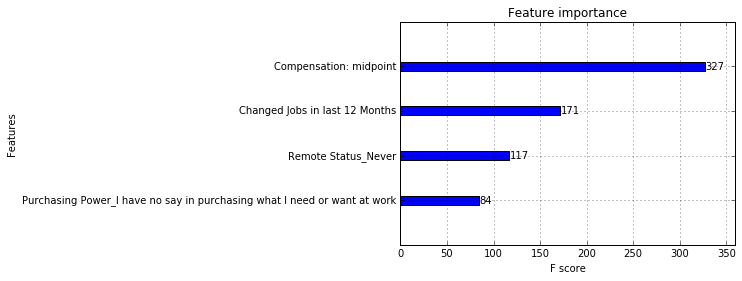

In [29]:
xgb_model = xgb.XGBRegressor()
#gridXGB = GridSearchCV(xgb_model, param_grid=parameters,scoring = scoring, cv=3, verbose=2, refit = 'mean')
#gridXGB.fit(X_train, y_train,eval_metric='rmse')
#print(gridXGB.best_params_)
#xgb_preds = gridXGB.predict(X_test)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
print (mean_squared_error(y_test,xgb_preds)**.5)
#xgb_copy = list(xgb_preds)
xgb_model.fit(X, y)
xgb_model._Booster.save_model('output2015.model')
xgb.plot_importance(xgb_model,max_num_features = 10)


In [19]:
parameters = { #when use hyperthread, xgboost may become slower
              'booster':['gbtree'],# dart is nice but far too slow
              'learning_rate': [.01], #
              'max_depth': [7],#1,3,5,6,7,8,10
              'min_child_weight': [8],#1,3,5,7,8,9,10
              'reg_alpha':[.01],#.0001,.001,.01,.1,1,10
              'silent': [0],
              'subsample': [.6],#.6,.7,.8,.9
              'gamma':[.001],#.1,.01,.001.,.005,0
              'colsample_bytree': [.8],#.6,.7,.8,.9
              'n_estimators': [10000], 
              'seed': [1337]
}

In [20]:
xgb_model = xgb.XGBRegressor()
gridXGB = GridSearchCV(xgb_model, param_grid=parameters,scoring = scoring, cv=3, verbose=2, refit = 'mean')
gridXGB.fit(X_train, y_train,eval_metric='rmse')
#print(gridXGB.best_params_)
xgb_preds = gridXGB.predict(X_test)
#xgb_model.fit(X_train, y_train)
#xgb_preds = xgb_model.predict(X_test)
print (mean_squared_error(y_test,xgb_preds)**.5)
#xgb_copy = list(xgb_preds)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] reg_alpha=0.01, colsample_bytree=0.8, silent=0, learning_rate=0.01, min_child_weight=8, n_estimators=10000, subsample=0.6, seed=1337, max_depth=7, gamma=0.001, booster=gbtree 
[CV]  reg_alpha=0.01, colsample_bytree=0.8, silent=0, learning_rate=0.01, min_child_weight=8, n_estimators=10000, subsample=0.6, seed=1337, max_depth=7, gamma=0.001, booster=gbtree, total=21.1min
[CV] reg_alpha=0.01, colsample_bytree=0.8, silent=0, learning_rate=0.01, min_child_weight=8, n_estimators=10000, subsample=0.6, seed=1337, max_depth=7, gamma=0.001, booster=gbtree 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 21.4min remaining:    0.0s


[CV]  reg_alpha=0.01, colsample_bytree=0.8, silent=0, learning_rate=0.01, min_child_weight=8, n_estimators=10000, subsample=0.6, seed=1337, max_depth=7, gamma=0.001, booster=gbtree, total=25.0min
[CV] reg_alpha=0.01, colsample_bytree=0.8, silent=0, learning_rate=0.01, min_child_weight=8, n_estimators=10000, subsample=0.6, seed=1337, max_depth=7, gamma=0.001, booster=gbtree 
[CV]  reg_alpha=0.01, colsample_bytree=0.8, silent=0, learning_rate=0.01, min_child_weight=8, n_estimators=10000, subsample=0.6, seed=1337, max_depth=7, gamma=0.001, booster=gbtree, total=21.7min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 68.6min finished


2.2666836788652214


In [9]:
print(gridXGB.best_params_)

NameError: name 'gridXGB' is not defined

In [17]:
print (mean_squared_error(y_test,xgb_preds)**.5)


2.322300794571225


In [47]:
print (sum(y_test)/len(y_test))
print (sum(xgb_preds)/len(xgb_preds))

7.5
7.492633136249195


In [6]:
parameters = {
    'n_estimators':[1],
    'learning_rate':[.1]
   # 'base_estimator':[ExtraTreesClassifier(160,class_weight='balanced')]
   # 'base_estimator':[grid]
}
modelABC = AdaBoostRegressor(base_estimator=xgb.XGBRegressor(reg_alpha=.01, colsample_bytree=.8, 
                                silent=0, learning_rate=.01, min_child_weight=8, n_estimators=10000, 
                                            subsample=.6, max_depth=7,gamma=.001,booster='gbtree'),n_estimators = 20)
#gridABC = GridSearchCV(modelABC, param_grid=parameters,scoring = scoring, cv=2, refit = 'mean',verbose=2)
modelABC.fit(X_train,y_train)
abc_preds = modelABC.predict(X_test)
print (mean_squared_error(y_test,abc_preds)**.5)
#print(gridABC.best_params_)
#print(model.feature_importances_)

2.2432018773173352


In [48]:
def clipS(preds):
    for pred, element in enumerate(preds):
        if preds[pred] < 1.25:
            preds[pred] = 0
        elif preds[pred] < 3.75:
            preds[pred] = 2.5
        elif  preds[pred] < 6.25:
            preds[pred] = 5
        elif  preds[pred] < 8.75:
            preds[pred] = 7.5
        else: 
            preds[pred] = 10
    return preds

In [49]:
for pred, clipped, actual in zip(xgb_preds, clipS(xgb_copy), y_test ):
    print (pred, clipped, actual)

8.286079 7.5 10.0
7.927208 7.5 7.5
6.8665676 7.5 7.5
7.365894 7.5 7.5
8.49939 7.5 5.0
7.1254463 7.5 5.0
6.702565 7.5 7.5
5.842753 5 7.5
8.738859 7.5 10.0
7.841649 7.5 10.0
6.74351 7.5 7.5
7.807215 7.5 7.5
9.261417 10 7.5
7.109841 7.5 5.0
6.8010564 7.5 7.5
7.597346 7.5 10.0
6.9410725 7.5 2.5
6.5449824 7.5 0.0
7.402582 7.5 5.0
6.431654 7.5 0.0
7.1956844 7.5 7.5
7.6999984 7.5 10.0
6.1977854 5 2.5
7.982983 7.5 10.0
7.190724 7.5 7.5
6.7932687 7.5 10.0
8.369915 7.5 7.5
8.421787 7.5 7.5
7.026611 7.5 7.5
6.857605 7.5 7.5
8.973689 10 10.0
6.7475266 7.5 2.5
8.897934 10 7.5
7.8295035 7.5 10.0
9.146121 10 10.0
8.495934 7.5 7.5
6.728901 7.5 7.5
7.36117 7.5 10.0
8.701159 7.5 10.0
7.6483 7.5 10.0
7.262645 7.5 7.5
7.3512554 7.5 7.5
7.0285273 7.5 10.0
8.729461 7.5 7.5
7.8325706 7.5 7.5
8.742565 7.5 10.0
6.331672 7.5 0.0
8.884819 10 7.5
7.004472 7.5 7.5
7.0543513 7.5 5.0
7.403653 7.5 10.0
7.0553303 7.5 7.5
7.1007104 7.5 7.5
4.405138 5 5.0
6.3311124 7.5 5.0
7.363051 7.5 5.0
6.0551515 5 2.5
9.117585 10 10

7.2498374 7.5 10.0
7.0629873 7.5 10.0
6.8996253 7.5 7.5
6.8121514 7.5 10.0
7.2658896 7.5 2.5
8.852533 10 10.0
7.584811 7.5 5.0
8.762749 10 10.0
6.7032113 7.5 7.5
7.040448 7.5 7.5
8.731287 7.5 10.0
8.339863 7.5 10.0
9.299665 10 10.0
7.84971 7.5 7.5
5.7796865 5 7.5
5.215879 5 2.5
6.0454664 5 5.0
7.069505 7.5 7.5
7.026026 7.5 10.0
8.7816305 10 7.5
7.6395483 7.5 10.0
8.811912 10 7.5
7.073048 7.5 7.5
6.7585797 7.5 7.5
5.5238676 5 7.5
7.074044 7.5 7.5
8.605527 7.5 10.0
4.81072 5 2.5
6.474626 7.5 10.0
7.489467 7.5 10.0
6.297437 7.5 7.5
9.015276 10 10.0
7.1141887 7.5 2.5
8.855669 10 7.5
7.5748086 7.5 7.5
7.4217353 7.5 10.0
7.6471562 7.5 7.5
6.816087 7.5 5.0
8.472724 7.5 10.0
6.552516 7.5 7.5
7.1472735 7.5 2.5
5.7331457 5 7.5
6.8766747 7.5 2.5
5.6829224 5 2.5
9.096558 10 10.0
7.444388 7.5 7.5
8.846415 10 7.5
7.449927 7.5 7.5
7.189878 7.5 7.5
6.0751224 5 10.0
7.364566 7.5 10.0
5.6063213 5 10.0
7.286406 7.5 7.5
7.6666327 7.5 7.5
6.3354225 7.5 10.0
5.25561 5 10.0
9.825521 10 10.0
6.786795 7.5 10.0

6.7574396 7.5 7.5
7.146657 7.5 10.0
8.529603 7.5 5.0
7.1334844 7.5 7.5
5.8378696 5 2.5
7.2832446 7.5 7.5
7.612223 7.5 7.5
6.818888 7.5 7.5
7.420518 7.5 7.5
7.2980275 7.5 5.0
5.7383604 5 2.5
6.2615175 7.5 7.5
6.6522627 7.5 7.5
6.1226707 5 7.5
4.436254 5 7.5
7.765819 7.5 7.5
7.6464105 7.5 5.0
7.4550295 7.5 10.0
8.247253 7.5 7.5
7.783889 7.5 10.0
6.8527164 7.5 7.5
7.6722775 7.5 7.5
7.215664 7.5 2.5
6.639135 7.5 10.0
7.11952 7.5 7.5
8.538041 7.5 10.0
9.917143 10 10.0
7.593615 7.5 10.0
8.31717 7.5 7.5
7.4880567 7.5 2.5
6.509329 7.5 7.5
6.3432565 7.5 2.5
8.837619 10 10.0
7.251931 7.5 7.5
5.1459727 5 2.5
4.7939253 5 0.0
7.554099 7.5 10.0
5.7530193 5 2.5
7.1315784 7.5 10.0
6.6707196 7.5 7.5
9.495126 10 10.0
7.509618 7.5 10.0
7.072568 7.5 10.0
8.936038 10 10.0
7.7594514 7.5 7.5
7.373159 7.5 10.0
7.533154 7.5 10.0
9.063518 10 7.5
6.768366 7.5 2.5
6.259156 7.5 7.5
7.2441187 7.5 7.5
7.7757993 7.5 7.5
6.8099904 7.5 5.0
6.2015033 5 2.5
6.786014 7.5 5.0
8.877727 10 10.0
8.141465 7.5 5.0
8.738115 7.5 

5.795179 5 2.5
8.171051 7.5 5.0
5.4485793 5 2.5
6.559353 7.5 10.0
8.21508 7.5 5.0
8.887403 10 10.0
6.473309 7.5 5.0
9.495146 10 10.0
6.067431 5 7.5
6.878742 7.5 7.5
7.1737523 7.5 5.0
7.470629 7.5 7.5
7.115641 7.5 0.0
5.6777554 5 5.0
5.8339877 5 2.5
7.111055 7.5 7.5
6.7236257 7.5 10.0
7.230857 7.5 2.5
6.8952537 7.5 5.0
7.876106 7.5 10.0
9.333084 10 7.5
6.7052875 7.5 10.0
8.9069605 10 7.5
9.08294 10 10.0
8.777982 10 10.0
8.99087 10 10.0
7.303084 7.5 10.0
7.020656 7.5 7.5
5.3853273 5 5.0
8.794083 10 10.0
8.935527 10 10.0
7.2178936 7.5 7.5
8.520957 7.5 5.0
7.0320234 7.5 2.5
8.815841 10 7.5
9.146775 10 10.0
9.14814 10 10.0
6.1299076 5 0.0
8.279397 7.5 7.5
8.929781 10 10.0
7.00511 7.5 10.0
7.3344545 7.5 10.0
7.4628363 7.5 10.0
6.5345902 7.5 5.0
7.4571605 7.5 7.5
5.4562893 5 7.5
8.557975 7.5 7.5
7.588536 7.5 7.5
8.936083 10 10.0
7.102791 7.5 5.0
8.20962 7.5 10.0
7.629561 7.5 10.0
6.944566 7.5 5.0
7.9404235 7.5 7.5
6.6885858 7.5 7.5
7.023529 7.5 7.5
5.356553 5 2.5
9.079288 10 10.0
7.165941 7.5

7.760685 7.5 10.0
8.821927 10 7.5
7.4442616 7.5 7.5
7.7990084 7.5 7.5
6.3827243 7.5 2.5
7.2358866 7.5 10.0
8.875368 10 10.0
6.5619397 7.5 5.0
9.182947 10 10.0
4.367136 5 7.5
7.6697392 7.5 7.5
7.6056943 7.5 7.5
7.1915956 7.5 10.0
8.1389675 7.5 10.0
8.704581 7.5 7.5
7.4515715 7.5 7.5
7.3995833 7.5 2.5
5.835661 5 2.5
8.826144 10 10.0
9.235827 10 7.5
5.5191054 5 5.0
6.203065 5 7.5
6.5741863 7.5 7.5
6.2972455 7.5 10.0
7.064277 7.5 5.0
5.743789 5 5.0
8.2548685 7.5 10.0
8.869461 10 10.0
7.3615146 7.5 7.5
6.889896 7.5 7.5
6.8485804 7.5 7.5
6.5264893 7.5 7.5
6.994022 7.5 7.5
7.7897563 7.5 10.0
8.830721 10 7.5
6.8106136 7.5 10.0
7.553045 7.5 10.0
6.657207 7.5 5.0
7.0640388 7.5 7.5
6.8612704 7.5 5.0
8.883724 10 7.5
7.7433324 7.5 7.5
7.1755404 7.5 10.0
7.748843 7.5 7.5
6.334149 7.5 5.0
9.155457 10 10.0
8.379332 7.5 10.0
8.09853 7.5 10.0
8.055823 7.5 7.5
6.5188313 7.5 10.0
8.244404 7.5 7.5
7.3874316 7.5 5.0
7.6197114 7.5 7.5
5.0924687 5 2.5
7.3565054 7.5 7.5
6.8516836 7.5 5.0
7.22283 7.5 7.5
8.5440

In [51]:
print (mean_squared_error(y_test,clipS(xgb_preds))**.5)

2.35883188889119


In [6]:
import tensorflow as tf
import keras
import theano
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
tf.logging.set_verbosity(tf.logging.INFO)
np.random.seed(123)  # for reproducibility
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

np.random.seed(1337)  # for reproducibility

/home/shrikar/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [39]:
model = Sequential()
model.add(Dense(346, input_dim=346, activation='relu'))
#model.add(Dense(200, activation='sigmoid'))
model.add(Dense(100, activation='hard_sigmoid'))
#model.add(Dense(50, activation='hard_sigmoid'))
#model.add(Dense(40, activation='sigmoid'))
#model.add(Dense(10, activation='sigmoid'))
#model.add(Dense(5, activation='sigmoid'))
model.add(Dense(1, activation='relu'))

model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(lr=.00001))

model.fit(X_train, y_train, epochs=60, batch_size=100)

nn_preds = model.predict(X_test)


Epoch 1/60
11202/11202 [==============================] - 2s 153us/step - loss: 55.9848
Epoch 2/60
11202/11202 [==============================] - 1s 67us/step - loss: 55.2120
Epoch 3/60
11202/11202 [==============================] - 1s 68us/step - loss: 54.4504
Epoch 4/60
11202/11202 [==============================] - 1s 67us/step - loss: 53.6961
Epoch 5/60
11202/11202 [==============================] - 1s 66us/step - loss: 52.9473
Epoch 6/60
11202/11202 [==============================] - 1s 67us/step - loss: 52.2075
Epoch 7/60
11202/11202 [==============================] - 1s 67us/step - loss: 51.4763
Epoch 8/60
11202/11202 [==============================] - 1s 67us/step - loss: 50.7543
Epoch 9/60
11202/11202 [==============================] - 1s 66us/step - loss: 50.0395
Epoch 10/60
11202/11202 [==============================] - 1s 68us/step - loss: 49.3346
Epoch 11/60
11202/11202 [==============================] - 1s 67us/step - loss: 48.6345
Epoch 12/60
11202/11202 [===============

In [33]:
print (mean_squared_error(y_test,nn_preds)**.5)

2.5509801292844245


In [16]:
# Refer https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
# Refer https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
# Aim of this is to show case use of keras and grid search libraries
print("Hello World!")
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
import numpy
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from keras.constraints import maxnorm

##############################################################
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)


def baseline_model():
    model = Sequential()
    model.add(Dense(346, input_dim=346, activation='relu'))
    model.add(Dense(100, activation='hard_sigmoid'))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

print("Hello World!")

estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=100, verbose=1)

# Use scikit-learn to grid search 
activation =  ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'softsign'] # softmax, softplus, softsign 
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
learn_rate = [.00001,.0001,0.001, 0.01, 0.1, 0.3]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
weight_constraint=[1, 2, 3, 4, 5]
neurons = [1, 5, 10, 15, 20, 25, 30]
init = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
optimizer = [ 'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']


# grid search epochs, batch size
epochs = [1, 10,50,100,150] # add 50, 100, 150 etc
batch_size = [5,50,100,200] # add 5, 10, 20, 40, 60, 80, 100 etc
param_grid = dict(epochs=epochs, batch_size=batch_size)

#gridSearch
grid = GridSearchCV(estimator=estimator, param_grid=param_grid, n_jobs=-1, verbose = 1)
grid_result = grid.fit(X_test, y_test) 


# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Hello World!
Hello World!
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Epoch 1/1
Epoch 1/1
Epoch 1/10
Epoch 1/1
3202/3202 [==============================] - 10s 3ms/step - loss: 62.7772
Epoch 2/10
3201/3201 [==============================] - 11s 3ms/step - loss: 62.5996
Epoch 2/10
3201/3201 [==============================] - 10s 3ms/step - loss: 62.5996
Epoch 3/10
3201/3201 [==============================] - 10s 3ms/step - loss: 62.8104
Epoch 5/10
3202/3202 [==============================] - 11s 3ms/step - loss: 62.7772
Epoch 4/10
3201/3201 [==============================] - 9s 3ms/step - loss: 62.8104
Epoch 6/50
3201/3201 [==============================] - 10s 3ms/step - loss: 62.5996
Epoch 6/10
3201/3201 [==============================] - 10s 3ms/step - loss: 62.5996
Epoch 7/10
3202/3202 [==============================] - 9s 3ms/step - loss: 62.7772
Epoch 8/10
3201/3201 [==============================] - 10s 3ms/step - loss: 62.8104
Epoch 10/10
3202/3202 [============

3201/3201 [==============================] - 9s 3ms/step - loss: 62.8104
Epoch 4/100
3201/3201 [==============================] - 8s 3ms/step - loss: 62.5996
Epoch 7/50
3201/3201 [==============================] - 8s 2ms/step - loss: 62.8104
Epoch 5/100
3201/3201 [==============================] - 11s 3ms/step - loss: 62.5996
Epoch 8/50
3201/3201 [==============================] - 11s 3ms/step - loss: 62.8104
Epoch 6/100
3202/3202 [==============================] - 12s 4ms/step - loss: 62.7772
Epoch 7/50
3201/3201 [==============================] - 13s 4ms/step - loss: 62.8104
Epoch 7/100
3201/3201 [==============================] - 9s 3ms/step - loss: 62.5996
Epoch 10/50
3202/3202 [==============================] - 11s 3ms/step - loss: 62.7772
Epoch 8/50
3201/3201 [==============================] - 9s 3ms/step - loss: 62.8104
Epoch 8/100
3201/3201 [==============================] - 8s 3ms/step - loss: 62.8104
Epoch 20/50
3201/3201 [==============================] - 9s 3ms/step - loss:

3201/3201 [==============================] - 11s 3ms/step - loss: 62.8104
Epoch 21/100
3201/3201 [==============================] - 11s 3ms/step - loss: 62.5996
Epoch 24/50
3202/3202 [==============================] - 10s 3ms/step - loss: 62.7772
Epoch 22/50
3201/3201 [==============================] - 9s 3ms/step - loss: 62.8104
Epoch 34/50
3201/3201 [==============================] - 8s 3ms/step - loss: 62.8104
Epoch 22/100
3201/3201 [==============================] - 8s 2ms/step - loss: 62.5996
Epoch 25/50
3202/3202 [==============================] - 8s 2ms/step - loss: 62.7772
Epoch 23/50
3201/3201 [==============================] - 6s 2ms/step - loss: 62.8104
Epoch 35/50
3201/3201 [==============================] - 6s 2ms/step - loss: 62.8104
Epoch 23/100
3201/3201 [==============================] - 6s 2ms/step - loss: 62.5996
Epoch 26/50
3201/3201 [==============================] - 5s 2ms/step - loss: 62.8104
Epoch 36/50
3201/3201 [==============================] - 6s 2ms/step - 

3202/3202 [==============================] - 6s 2ms/step - loss: 62.7772
Epoch 41/50
3201/3201 [==============================] - 7s 2ms/step - loss: 62.5996
Epoch 43/50
3201/3201 [==============================] - 6s 2ms/step - loss: 62.8104
Epoch 40/100
3201/3201 [==============================] - 7s 2ms/step - loss: 9.6839
Epoch 2/100
3202/3202 [==============================] - 7s 2ms/step - loss: 62.7772
Epoch 42/50
3201/3201 [==============================] - 6s 2ms/step - loss: 62.5996
Epoch 44/50
3201/3201 [==============================] - 7s 2ms/step - loss: 6.6730
Epoch 3/100
3201/3201 [==============================] - 7s 2ms/step - loss: 62.5996
Epoch 45/50
3201/3201 [==============================] - 7s 2ms/step - loss: 62.5996
Epoch 46/50
3201/3201 [==============================] - 6s 2ms/step - loss: 6.6790
Epoch 5/100
3202/3202 [==============================] - 7s 2ms/step - loss: 62.7772
Epoch 45/50
3201/3201 [==============================] - 7s 2ms/step - loss: 62

3201/3201 [==============================] - 13s 4ms/step - loss: 62.8104
Epoch 7/150
3202/3202 [==============================] - 9s 3ms/step - loss: 6.1854
Epoch 10/100
3201/3201 [==============================] - 10s 3ms/step - loss: 62.8104
Epoch 58/100
3201/3201 [==============================] - 10s 3ms/step - loss: 6.6984
Epoch 20/100
3202/3202 [==============================] - 10s 3ms/step - loss: 6.1802
Epoch 11/100
3201/3201 [==============================] - 10s 3ms/step - loss: 62.8104
Epoch 59/100
3201/3201 [==============================] - 9s 3ms/step - loss: 6.6915
Epoch 21/100
3201/3201 [==============================] - 9s 3ms/step - loss: 62.8104
Epoch 10/150
3201/3201 [==============================] - 8s 2ms/step - loss: 62.8104
Epoch 60/100
3201/3201 [==============================] - 7s 2ms/step - loss: 6.6937
Epoch 22/100
3202/3202 [==============================] - 6s 2ms/step - loss: 6.1763
Epoch 13/100
3201/3201 [==============================] - 6s 2ms/step

3202/3202 [==============================] - 9s 3ms/step - loss: 6.1779
Epoch 28/100
3201/3201 [==============================] - 10s 3ms/step - loss: 62.8104
Epoch 75/100
3201/3201 [==============================] - 8s 2ms/step - loss: 6.6952
Epoch 38/100
3201/3201 [==============================] - 8s 3ms/step - loss: 62.8104
Epoch 27/150
3201/3201 [==============================] - 7s 2ms/step - loss: 6.6931
Epoch 39/100
3201/3201 [==============================] - 7s 2ms/step - loss: 62.8104
Epoch 77/100
3201/3201 [==============================] - 7s 2ms/step - loss: 62.8104
Epoch 28/150
3202/3202 [==============================] - 7s 2ms/step - loss: 6.1814
Epoch 30/100
3201/3201 [==============================] - 7s 2ms/step - loss: 6.6922
Epoch 40/100
3201/3201 [==============================] - 8s 2ms/step - loss: 62.8104
Epoch 78/100
3202/3202 [==============================] - 7s 2ms/step - loss: 6.1845
Epoch 31/100
3201/3201 [==============================] - 7s 2ms/step - 

3201/3201 [==============================] - 11s 3ms/step - loss: 62.8104
Epoch 44/150
3201/3201 [==============================] - 9s 3ms/step - loss: 62.8104
Epoch 94/100
3201/3201 [==============================] - 9s 3ms/step - loss: 62.8104
Epoch 45/150
3201/3201 [==============================] - 8s 3ms/step - loss: 6.6969
Epoch 58/100
3201/3201 [==============================] - 9s 3ms/step - loss: 62.8104
Epoch 95/100
3202/3202 [==============================] - 10s 3ms/step - loss: 6.1801
Epoch 49/100
3201/3201 [==============================] - 9s 3ms/step - loss: 62.8104
Epoch 48/150
3201/3201 [==============================] - 8s 2ms/step - loss: 6.6844
Epoch 61/100
3201/3201 [==============================] - 9s 3ms/step - loss: 62.8104
Epoch 49/150
3201/3201 [==============================] - 8s 2ms/step - loss: 62.8104
Epoch 98/100
3201/3201 [==============================] - 9s 3ms/step - loss: 6.6986
Epoch 62/100
3201/3201 [==============================] - 8s 3ms/step

3201/3201 [==============================] - 8s 3ms/step - loss: 62.8104
Epoch 61/150
3201/3201 [==============================] - 7s 2ms/step - loss: 62.5996
Epoch 10/150
3201/3201 [==============================] - 8s 3ms/step - loss: 6.6831
Epoch 75/100
3201/3201 [==============================] - 7s 2ms/step - loss: 62.5996
Epoch 11/150
3201/3201 [==============================] - 8s 3ms/step - loss: 62.8104
Epoch 63/150
3201/3201 [==============================] - 7s 2ms/step - loss: 62.5996
Epoch 12/150
3202/3202 [==============================] - 7s 2ms/step - loss: 6.1683
Epoch 66/100
3201/3201 [==============================] - 8s 2ms/step - loss: 62.8104
Epoch 64/150
3201/3201 [==============================] - 8s 2ms/step - loss: 62.5996
Epoch 13/150
3202/3202 [==============================] - 7s 2ms/step - loss: 6.1732
Epoch 67/100
3201/3201 [==============================] - 8s 2ms/step - loss: 6.6807
Epoch 78/100
3202/3202 [==============================] - 8s 3ms/step -

3201/3201 [==============================] - 7s 2ms/step - loss: 62.8104
Epoch 79/150
3202/3202 [==============================] - 8s 2ms/step - loss: 6.1860
Epoch 81/100
3201/3201 [==============================] - 7s 2ms/step - loss: 6.6900
Epoch 93/100
3201/3201 [==============================] - 8s 2ms/step - loss: 62.5996
Epoch 29/150
3202/3202 [==============================] - 9s 3ms/step - loss: 6.1903
Epoch 82/100
3201/3201 [==============================] - 7s 2ms/step - loss: 6.6891
Epoch 94/100
3201/3201 [==============================] - 8s 2ms/step - loss: 62.8104
Epoch 81/150
3201/3201 [==============================] - 8s 2ms/step - loss: 62.5996
Epoch 30/150
3201/3201 [==============================] - 7s 2ms/step - loss: 6.6844
Epoch 95/100
3202/3202 [==============================] - 7s 2ms/step - loss: 6.1904
Epoch 84/100
3202/3202 [==============================] - 7s 2ms/step - loss: 6.1888
Epoch 85/100
3201/3201 [==============================] - 8s 3ms/step - lo

3201/3201 [==============================] - 7s 2ms/step - loss: 62.8104
Epoch 97/150
3202/3202 [==============================] - 8s 3ms/step - loss: 6.1847
Epoch 100/100
3201/3201 [==============================] - 7s 2ms/step - loss: 62.8104
Epoch 100/150
3201/3201 [==============================] - 7s 2ms/step - loss: 62.5996
Epoch 49/150
3202/3202 [==============================] - 8s 2ms/step - loss: 6.1798
Epoch 13/150
3201/3201 [==============================] - 7s 2ms/step - loss: 62.8104
Epoch 101/150
3201/3201 [==============================] - 7s 2ms/step - loss: 62.5996
Epoch 50/150
3202/3202 [==============================] - 7s 2ms/step - loss: 6.1852
Epoch 14/150
3201/3201 [==============================] - 6s 2ms/step - loss: 62.8104
Epoch 102/150
3201/3201 [==============================] - 7s 2ms/step - loss: 62.5996
Epoch 51/150
3201/3201 [==============================] - 2s 631us/step - loss: 34.0669
Epoch 2/10
3201/3201 [==============================] - 1s 250us

3201/3201 [==============================] - 7s 2ms/step - loss: 62.8104
Epoch 107/150
3201/3201 [==============================] - 2s 604us/step - loss: 32.0785
Epoch 2/50
3201/3201 [==============================] - 1s 273us/step - loss: 12.6061
Epoch 3/50
3201/3201 [==============================] - 1s 300us/step - loss: 6.6893
Epoch 5/50
3201/3201 [==============================] - 1s 275us/step - loss: 6.6352
Epoch 6/50
3201/3201 [==============================] - 7s 2ms/step - loss: 62.8104
Epoch 108/150
3201/3201 [==============================] - 1s 282us/step - loss: 6.6328
Epoch 7/50
3201/3201 [==============================] - 1s 258us/step - loss: 6.6363
Epoch 8/50
3202/3202 [==============================] - 7s 2ms/step - loss: 6.1672
Epoch 21/150
3201/3201 [==============================] - 1s 289us/step - loss: 6.6369
Epoch 9/50
3201/3201 [==============================] - 1s 250us/step - loss: 6.6387
Epoch 10/50
3201/3201 [==============================] - 1s 219us/step

3201/3201 [==============================] - 7s 2ms/step - loss: 62.8104
Epoch 114/150
3201/3201 [==============================] - 2s 761us/step - loss: 26.5088
Epoch 2/50
3201/3201 [==============================] - 7s 2ms/step - loss: 62.5996
Epoch 63/150
3202/3202 [==============================] - 7s 2ms/step - loss: 6.1677
Epoch 28/150
3201/3201 [==============================] - 1s 314us/step - loss: 6.6559
Epoch 8/50
3201/3201 [==============================] - 1s 281us/step - loss: 6.6566
Epoch 9/50
3201/3201 [==============================] - 1s 243us/step - loss: 6.6576
Epoch 10/50
3201/3201 [==============================] - 1s 251us/step - loss: 6.6596
Epoch 11/50
3201/3201 [==============================] - 1s 295us/step - loss: 6.6554
Epoch 12/50
3201/3201 [==============================] - 1s 275us/step - loss: 6.6553
Epoch 14/50
3201/3201 [==============================] - 8s 2ms/step - loss: 62.8104
Epoch 116/150
3201/3201 [==============================] - 1s 273us/s

Epoch 3/50
3202/3202 [==============================] - 1s 274us/step - loss: 62.7772
Epoch 4/50
3202/3202 [==============================] - 1s 256us/step - loss: 62.7772
Epoch 5/50
3202/3202 [==============================] - 1s 282us/step - loss: 62.7772
Epoch 6/50
3201/3201 [==============================] - 7s 2ms/step - loss: 62.5996
Epoch 70/150
3202/3202 [==============================] - 1s 269us/step - loss: 62.7772
Epoch 7/50
3202/3202 [==============================] - 1s 239us/step - loss: 62.7772
Epoch 8/50
3202/3202 [==============================] - 1s 296us/step - loss: 62.7772
Epoch 10/50
3202/3202 [==============================] - 8s 2ms/step - loss: 6.1758
Epoch 35/150
3202/3202 [==============================] - 1s 240us/step - loss: 62.7772
Epoch 12/50
3202/3202 [==============================] - 1s 259us/step - loss: 62.7772
Epoch 13/50
3202/3202 [==============================] - 1s 287us/step - loss: 62.7772
Epoch 14/50
3202/3202 [=============================

3201/3201 [==============================] - 1s 285us/step - loss: 18.2968
Epoch 3/100
3202/3202 [==============================] - 6s 2ms/step - loss: 6.1996
Epoch 41/150
3201/3201 [==============================] - 1s 305us/step - loss: 7.0721
Epoch 5/100
3201/3201 [==============================] - 7s 2ms/step - loss: 62.5996
Epoch 77/150
3201/3201 [==============================] - 1s 244us/step - loss: 6.6886
Epoch 6/100
3201/3201 [==============================] - 1s 274us/step - loss: 6.6322
Epoch 7/100
3201/3201 [==============================] - 1s 268us/step - loss: 6.6321
Epoch 8/100
3201/3201 [==============================] - 7s 2ms/step - loss: 62.8104
Epoch 129/150
3201/3201 [==============================] - 1s 280us/step - loss: 6.6320
Epoch 10/100
3201/3201 [==============================] - 1s 287us/step - loss: 6.6316
Epoch 11/100
3202/3202 [==============================] - 7s 2ms/step - loss: 6.1825
Epoch 42/150
3201/3201 [==============================] - 1s 303u

3201/3201 [==============================] - 8s 2ms/step - loss: 62.8104
Epoch 135/150
3201/3201 [==============================] - 1s 226us/step - loss: 6.6456
Epoch 56/100
3201/3201 [==============================] - 1s 321us/step - loss: 6.6372
Epoch 57/100
3201/3201 [==============================] - 1s 327us/step - loss: 6.6377
Epoch 58/100
3201/3201 [==============================] - 1s 229us/step - loss: 6.6357
Epoch 59/100
3201/3201 [==============================] - 1s 255us/step - loss: 6.6445
Epoch 60/100
3201/3201 [==============================] - 1s 294us/step - loss: 6.6382
Epoch 61/100
3201/3201 [==============================] - 1s 357us/step - loss: 6.6351
Epoch 62/100
3201/3201 [==============================] - 1s 328us/step - loss: 6.6493
Epoch 63/100
3202/3202 [==============================] - 7s 2ms/step - loss: 6.1885
Epoch 49/150
3201/3201 [==============================] - 1s 214us/step - loss: 6.6386
Epoch 64/100
3201/3201 [==============================] - 

3201/3201 [==============================] - 1s 383us/step - loss: 62.5996
Epoch 6/100
3201/3201 [==============================] - 1s 327us/step - loss: 62.5996
Epoch 7/100
3201/3201 [==============================] - 1s 404us/step - loss: 62.5996
Epoch 8/100
3201/3201 [==============================] - 8s 3ms/step - loss: 62.5996
Epoch 91/150
3201/3201 [==============================] - 1s 306us/step - loss: 62.5996
Epoch 10/100
3202/3202 [==============================] - 8s 2ms/step - loss: 6.1695
Epoch 56/150
3201/3201 [==============================] - 1s 296us/step - loss: 62.5996
Epoch 11/100
3201/3201 [==============================] - 8s 3ms/step - loss: 62.8104
Epoch 143/150
3201/3201 [==============================] - 1s 272us/step - loss: 62.5996
Epoch 12/100
3201/3201 [==============================] - 1s 407us/step - loss: 62.5996
Epoch 13/100
3201/3201 [==============================] - 1s 193us/step - loss: 62.5996
Epoch 15/100
3201/3201 [==============================

Epoch 62/150
3201/3201 [==============================] - 1s 242us/step - loss: 62.5996
Epoch 57/100
3201/3201 [==============================] - 1s 248us/step - loss: 62.5996
Epoch 58/100
3201/3201 [==============================] - 1s 209us/step - loss: 62.5996
Epoch 60/100
3201/3201 [==============================] - 1s 351us/step - loss: 62.5996
Epoch 62/100
3201/3201 [==============================] - 1s 372us/step - loss: 62.5996
Epoch 64/100
3202/3202 [==============================] - 8s 2ms/step - loss: 6.1776
Epoch 63/150
3201/3201 [==============================] - 8s 3ms/step - loss: 62.8104
Epoch 150/150
3201/3201 [==============================] - 1s 389us/step - loss: 62.5996
Epoch 66/100
3201/3201 [==============================] - 2s 494us/step - loss: 62.5996
Epoch 67/100
3201/3201 [==============================] - 1s 299us/step - loss: 62.5996
Epoch 68/100
3201/3201 [==============================] - 1s 274us/step - loss: 62.5996
Epoch 69/100
3201/3201 [============

3202/3202 [==============================] - 1s 388us/step - loss: 6.1570
Epoch 100/100
Epoch 19/100
3202/3202 [==============================] - 1s 423us/step - loss: 6.1542
Epoch 20/100
3202/3202 [==============================] - 1s 370us/step - loss: 6.1531
Epoch 21/100
3202/3202 [==============================] - 1s 410us/step - loss: 6.1542
Epoch 22/100
3201/3201 [==============================] - 9s 3ms/step - loss: 62.5996
Epoch 103/150
3202/3202 [==============================] - 1s 239us/step - loss: 6.1538
Epoch 23/100
3202/3202 [==============================] - 9s 3ms/step - loss: 6.1792
Epoch 68/150
3202/3202 [==============================] - 1s 194us/step - loss: 6.1550
Epoch 24/100
3202/3202 [==============================] - 1s 196us/step - loss: 6.1549
Epoch 25/100
3202/3202 [==============================] - 1s 235us/step - loss: 6.1540
Epoch 26/100
3201/3201 [==============================] - 2s 749us/step - loss: 35.2356
Epoch 2/150
3201/3201 [====================

Epoch 31/150
3201/3201 [==============================] - 1s 234us/step - loss: 6.6445
Epoch 32/150
3202/3202 [==============================] - 1s 262us/step - loss: 6.1592
Epoch 57/100
3201/3201 [==============================] - 1s 234us/step - loss: 6.6449
Epoch 33/150
3202/3202 [==============================] - 1s 263us/step - loss: 6.1626
Epoch 58/100
3201/3201 [==============================] - 1s 251us/step - loss: 6.6380
Epoch 35/150
3202/3202 [==============================] - 1s 258us/step - loss: 6.1600
Epoch 60/100
3201/3201 [==============================] - 1s 273us/step - loss: 6.6430
Epoch 36/150
3202/3202 [==============================] - 1s 267us/step - loss: 6.1541
Epoch 61/100
3202/3202 [==============================] - 1s 227us/step - loss: 6.1577
Epoch 62/100
3201/3201 [==============================] - 1s 262us/step - loss: 6.6364
Epoch 37/150
3201/3201 [==============================] - 7s 2ms/step - loss: 62.5996
Epoch 108/150
3202/3202 [===================

3201/3201 [==============================] - 1s 327us/step - loss: 6.6387
Epoch 67/150
3202/3202 [==============================] - 1s 260us/step - loss: 6.1585
Epoch 93/100
3202/3202 [==============================] - 7s 2ms/step - loss: 6.1839
Epoch 77/150
3201/3201 [==============================] - 7s 2ms/step - loss: 62.5996
Epoch 112/150
3201/3201 [==============================] - 1s 352us/step - loss: 6.6878
Epoch 68/150
3202/3202 [==============================] - 1s 347us/step - loss: 6.1561
Epoch 94/100
3202/3202 [==============================] - 1s 280us/step - loss: 6.1625
Epoch 95/100
3202/3202 [==============================] - 1s 348us/step - loss: 6.1620
Epoch 97/100
3202/3202 [==============================] - 1s 266us/step - loss: 6.1581
Epoch 98/100
3202/3202 [==============================] - 1s 264us/step - loss: 6.1529
Epoch 99/100
3201/3201 [==============================] - 1s 277us/step - loss: 6.6495
Epoch 74/150
3201/3201 [==============================] - 

Epoch 116/150
3201/3201 [==============================] - 1s 250us/step - loss: 6.6620
Epoch 22/150
3201/3201 [==============================] - 1s 315us/step - loss: 6.6374
Epoch 99/150
3201/3201 [==============================] - 1s 294us/step - loss: 6.6603
Epoch 23/150
3201/3201 [==============================] - 1s 354us/step - loss: 6.6419
Epoch 100/150
3201/3201 [==============================] - 1s 250us/step - loss: 6.6577
Epoch 24/150
3201/3201 [==============================] - 1s 325us/step - loss: 6.6624
Epoch 101/150
3201/3201 [==============================] - 1s 269us/step - loss: 6.6554
Epoch 25/150
3201/3201 [==============================] - 1s 334us/step - loss: 6.6578
Epoch 26/150
3201/3201 [==============================] - 1s 381us/step - loss: 6.6563
Epoch 27/150
3201/3201 [==============================] - 1s 280us/step - loss: 6.6537
Epoch 104/150
3201/3201 [==============================] - 1s 267us/step - loss: 6.6689
Epoch 28/150
3202/3202 [===============

3201/3201 [==============================] - 1s 263us/step - loss: 6.6690
Epoch 132/150
3201/3201 [==============================] - 1s 259us/step - loss: 6.6436
Epoch 134/150
3201/3201 [==============================] - 1s 240us/step - loss: 6.6568
Epoch 59/150
3201/3201 [==============================] - 1s 249us/step - loss: 6.6375
Epoch 135/150
3202/3202 [==============================] - 7s 2ms/step - loss: 6.1941
Epoch 86/150
3201/3201 [==============================] - 1s 233us/step - loss: 6.6400
Epoch 136/150
3201/3201 [==============================] - 1s 237us/step - loss: 6.6661
Epoch 61/150
3201/3201 [==============================] - 1s 253us/step - loss: 6.6463
Epoch 137/150
3201/3201 [==============================] - 1s 254us/step - loss: 6.6698
Epoch 62/150
3201/3201 [==============================] - 1s 227us/step - loss: 6.6269
Epoch 138/150
3201/3201 [==============================] - 7s 2ms/step - loss: 62.5996
Epoch 121/150
3201/3201 [============================

3202/3202 [==============================] - 7s 2ms/step - loss: 6.1780
Epoch 90/150
3202/3202 [==============================] - 1s 244us/step - loss: 62.7772
Epoch 12/150
3201/3201 [==============================] - 1s 240us/step - loss: 6.6777
Epoch 93/150
3202/3202 [==============================] - 1s 261us/step - loss: 62.7772
Epoch 13/150
3201/3201 [==============================] - 1s 262us/step - loss: 6.6573
Epoch 94/150
3201/3201 [==============================] - 7s 2ms/step - loss: 62.5996
Epoch 125/150
3201/3201 [==============================] - 1s 245us/step - loss: 6.6643
Epoch 95/150
3202/3202 [==============================] - 1s 279us/step - loss: 62.7772
Epoch 15/150
3201/3201 [==============================] - 1s 279us/step - loss: 6.6850
Epoch 96/150
3202/3202 [==============================] - 1s 227us/step - loss: 62.7772
Epoch 16/150
3201/3201 [==============================] - 1s 250us/step - loss: 6.6562
Epoch 97/150
3201/3201 [==============================

3201/3201 [==============================] - 1s 230us/step - loss: 6.6648
Epoch 126/150
3202/3202 [==============================] - 1s 238us/step - loss: 62.7772
Epoch 45/150
3201/3201 [==============================] - 7s 2ms/step - loss: 62.5996
Epoch 129/150
3202/3202 [==============================] - 1s 248us/step - loss: 62.7772
Epoch 127/150
3201/3201 [==============================] - 1s 260us/step - loss: 6.6592
Epoch 128/150
3201/3201 [==============================] - 1s 279us/step - loss: 6.6667
Epoch 129/150
3202/3202 [==============================] - 1s 276us/step - loss: 62.7772
Epoch 48/150
3201/3201 [==============================] - 1s 236us/step - loss: 6.6630
Epoch 130/150
3202/3202 [==============================] - 7s 2ms/step - loss: 6.2080
Epoch 95/150
3201/3201 [==============================] - 1s 261us/step - loss: 6.6663
Epoch 132/150
3202/3202 [==============================] - 1s 254us/step - loss: 62.7772
Epoch 51/150
3202/3202 [========================

3202/3202 [==============================] - 1s 255us/step - loss: 62.7772
Epoch 80/150
3202/3202 [==============================] - 1s 228us/step - loss: 62.7772
Epoch 81/150
3202/3202 [==============================] - 1s 198us/step - loss: 62.7772
Epoch 82/150
3202/3202 [==============================] - 1s 218us/step - loss: 62.7772
Epoch 83/150
3201/3201 [==============================] - 6s 2ms/step - loss: 62.5996
Epoch 134/150
3202/3202 [==============================] - 1s 255us/step - loss: 62.7772
Epoch 84/150
3202/3202 [==============================] - 1s 225us/step - loss: 62.7772
Epoch 85/150
3202/3202 [==============================] - 1s 221us/step - loss: 62.7772
Epoch 86/150
3202/3202 [==============================] - 1s 191us/step - loss: 62.7772
Epoch 87/150
3202/3202 [==============================] - 1s 198us/step - loss: 62.7772
Epoch 88/150
3202/3202 [==============================] - 6s 2ms/step - loss: 6.1888
Epoch 100/150
3201/3201 [========================

3202/3202 [==============================] - 1s 283us/step - loss: 62.7772
Epoch 113/150
3202/3202 [==============================] - 1s 169us/step - loss: 6.2245
Epoch 8/10
3202/3202 [==============================] - 1s 232us/step - loss: 6.1659
Epoch 9/10
3201/3201 [==============================] - 7s 2ms/step - loss: 62.5996
Epoch 138/150
3202/3202 [==============================] - 1s 184us/step - loss: 62.7772
Epoch 116/150
3202/3202 [==============================] - 1s 202us/step - loss: 62.7772
Epoch 117/150
3202/3202 [==============================] - 1s 199us/step - loss: 62.7772
Epoch 119/150
3202/3202 [==============================] - 1s 231us/step - loss: 62.7772
Epoch 120/150
3201/3201 [==============================] - 1s 157us/step - loss: 30.1159
Epoch 3/50
3201/3201 [==============================] - 0s 151us/step - loss: 19.5171
Epoch 4/50
3201/3201 [==============================] - 6s 2ms/step - loss: 62.5996
Epoch 139/150
3202/3202 [============================

3201/3201 [==============================] - 0s 132us/step - loss: 6.6330
Epoch 38/50
3202/3202 [==============================] - 1s 259us/step - loss: 62.7772
Epoch 141/150
3202/3202 [==============================] - 7s 2ms/step - loss: 6.1808
Epoch 107/150
3202/3202 [==============================] - 1s 268us/step - loss: 62.7772
Epoch 142/150
3201/3201 [==============================] - 0s 142us/step - loss: 6.6395
Epoch 42/50
3202/3202 [==============================] - 1s 279us/step - loss: 62.7772
Epoch 144/150
3201/3201 [==============================] - 1s 157us/step - loss: 6.6354
Epoch 45/50
3202/3202 [==============================] - 1s 240us/step - loss: 62.7772
Epoch 145/150
3201/3201 [==============================] - 1s 160us/step - loss: 6.6328
Epoch 46/50
3201/3201 [==============================] - 1s 168us/step - loss: 6.6328
Epoch 47/50
3202/3202 [==============================] - 1s 225us/step - loss: 62.7772
Epoch 146/150
3201/3201 [============================

3202/3202 [==============================] - 1s 158us/step - loss: 62.7772
Epoch 17/50
3201/3201 [==============================] - 1s 158us/step - loss: 62.5996
Epoch 23/50
3202/3202 [==============================] - 1s 160us/step - loss: 62.7772
Epoch 18/50
3201/3201 [==============================] - 1s 166us/step - loss: 62.5996
Epoch 24/50
3202/3202 [==============================] - 1s 156us/step - loss: 62.7772
Epoch 19/50
3201/3201 [==============================] - 1s 170us/step - loss: 62.5996
Epoch 25/50
3202/3202 [==============================] - 1s 160us/step - loss: 62.7772
Epoch 20/50
3202/3202 [==============================] - 0s 154us/step - loss: 62.7772
Epoch 21/50
3201/3201 [==============================] - 1s 168us/step - loss: 62.5996
Epoch 27/50
3201/3201 [==============================] - 6s 2ms/step - loss: 62.5996
Epoch 145/150
3202/3202 [==============================] - 1s 162us/step - loss: 62.7772
Epoch 23/50
3201/3201 [==============================] 

3201/3201 [==============================] - 2s 661us/step - loss: 62.5996
Epoch 2/100
3201/3201 [==============================] - 0s 150us/step - loss: 8.5815
Epoch 6/100
3201/3201 [==============================] - 0s 151us/step - loss: 62.5996
Epoch 3/100
3201/3201 [==============================] - 1s 166us/step - loss: 7.3345
Epoch 7/100
3201/3201 [==============================] - 0s 149us/step - loss: 62.5996
Epoch 4/100
3201/3201 [==============================] - 0s 156us/step - loss: 6.8627
Epoch 8/100
3201/3201 [==============================] - 1s 157us/step - loss: 62.5996
Epoch 5/100
3201/3201 [==============================] - 0s 148us/step - loss: 6.6998
Epoch 9/100
3201/3201 [==============================] - 1s 199us/step - loss: 62.5996
Epoch 6/100
3201/3201 [==============================] - 0s 147us/step - loss: 6.6490
Epoch 10/100
3201/3201 [==============================] - 0s 142us/step - loss: 6.6453
Epoch 11/100
3201/3201 [==============================] - 1s

3201/3201 [==============================] - 0s 139us/step - loss: 62.5996
Epoch 38/100
3201/3201 [==============================] - 0s 137us/step - loss: 6.6350
Epoch 42/100
3201/3201 [==============================] - 1s 160us/step - loss: 62.5996
Epoch 39/100
3201/3201 [==============================] - 1s 170us/step - loss: 6.6314
Epoch 43/100
3201/3201 [==============================] - 1s 168us/step - loss: 62.5996
Epoch 40/100
3201/3201 [==============================] - 1s 170us/step - loss: 6.6374
Epoch 44/100
3201/3201 [==============================] - 0s 153us/step - loss: 62.5996
Epoch 41/100
3201/3201 [==============================] - 1s 170us/step - loss: 6.6380
Epoch 45/100
3201/3201 [==============================] - 0s 152us/step - loss: 62.5996
Epoch 43/100
3201/3201 [==============================] - 0s 127us/step - loss: 6.6387
Epoch 47/100
3201/3201 [==============================] - 0s 125us/step - loss: 62.5996
Epoch 44/100
3201/3201 [==========================

3201/3201 [==============================] - 1s 161us/step - loss: 62.5996
Epoch 68/100
3201/3201 [==============================] - 1s 174us/step - loss: 6.6364
Epoch 72/100
3202/3202 [==============================] - 0s 123us/step - loss: 6.1526
Epoch 13/100
3202/3202 [==============================] - 0s 146us/step - loss: 6.1526
Epoch 14/100
3201/3201 [==============================] - 0s 152us/step - loss: 62.5996
Epoch 70/100
3201/3201 [==============================] - 0s 148us/step - loss: 6.6327
Epoch 74/100
3201/3201 [==============================] - 0s 148us/step - loss: 6.6464
Epoch 16/100
Epoch 75/100
3201/3201 [==============================] - 1s 161us/step - loss: 62.5996
Epoch 71/100
3202/3202 [==============================] - 0s 153us/step - loss: 6.1539
Epoch 17/100
3201/3201 [==============================] - 1s 161us/step - loss: 6.6383
Epoch 76/100
3201/3201 [==============================] - 1s 163us/step - loss: 62.5996
Epoch 72/100
3202/3202 [===============

3202/3202 [==============================] - 0s 146us/step - loss: 6.1551
Epoch 37/100
3202/3202 [==============================] - 1s 167us/step - loss: 6.1552
Epoch 38/100
3201/3201 [==============================] - 0s 145us/step - loss: 62.5996
Epoch 93/100
3201/3201 [==============================] - 1s 158us/step - loss: 6.6329
Epoch 97/100
3202/3202 [==============================] - 1s 162us/step - loss: 6.1659
Epoch 39/100
3201/3201 [==============================] - 0s 154us/step - loss: 62.5996
Epoch 94/100
3201/3201 [==============================] - 1s 175us/step - loss: 6.6650
Epoch 98/100
3202/3202 [==============================] - 0s 154us/step - loss: 6.1895
Epoch 40/100
3201/3201 [==============================] - 0s 144us/step - loss: 62.5996
Epoch 95/100
3201/3201 [==============================] - 1s 158us/step - loss: 6.6372
Epoch 99/100
3202/3202 [==============================] - 0s 154us/step - loss: 6.1618
Epoch 41/100
3201/3201 [=============================

3201/3201 [==============================] - 0s 153us/step - loss: 6.7069
Epoch 12/150
3202/3202 [==============================] - 0s 132us/step - loss: 6.1553
Epoch 69/100
3201/3201 [==============================] - 0s 141us/step - loss: 62.8104
Epoch 19/150
3202/3202 [==============================] - 0s 143us/step - loss: 6.1543
Epoch 70/100
3201/3201 [==============================] - 0s 141us/step - loss: 6.6610
Epoch 14/150
3201/3201 [==============================] - 1s 162us/step - loss: 62.8104
Epoch 20/150
3201/3201 [==============================] - 1s 159us/step - loss: 6.6601
Epoch 15/150
3201/3201 [==============================] - 1s 171us/step - loss: 62.8104
Epoch 21/150
3201/3201 [==============================] - 0s 149us/step - loss: 6.6558
Epoch 16/150
3201/3201 [==============================] - 0s 132us/step - loss: 62.8104
Epoch 22/150
3202/3202 [==============================] - 1s 162us/step - loss: 6.1649
Epoch 73/100
3202/3202 [============================

3201/3201 [==============================] - 0s 134us/step - loss: 62.8104
Epoch 42/150
3201/3201 [==============================] - 0s 142us/step - loss: 6.6569
Epoch 37/150
3202/3202 [==============================] - 0s 136us/step - loss: 6.1556
Epoch 95/100
3201/3201 [==============================] - 0s 140us/step - loss: 62.8104
Epoch 43/150
3201/3201 [==============================] - 0s 156us/step - loss: 6.6545
Epoch 38/150
3202/3202 [==============================] - 0s 139us/step - loss: 6.1566
Epoch 96/100
3201/3201 [==============================] - 0s 131us/step - loss: 6.6574
Epoch 39/150
3202/3202 [==============================] - 0s 129us/step - loss: 6.1534
Epoch 97/100
3201/3201 [==============================] - 1s 177us/step - loss: 62.8104
Epoch 98/100
Epoch 45/150
3201/3201 [==============================] - 0s 133us/step - loss: 62.8104
Epoch 46/150
3202/3202 [==============================] - 0s 140us/step - loss: 6.1630
Epoch 99/100
3201/3201 [===============

3201/3201 [==============================] - 0s 134us/step - loss: 6.6533
Epoch 63/150
3202/3202 [==============================] - 0s 145us/step - loss: 6.1528
Epoch 15/150
3201/3201 [==============================] - 0s 137us/step - loss: 6.6554
Epoch 64/150
3201/3201 [==============================] - 0s 142us/step - loss: 62.8104
Epoch 69/150
Epoch 16/150
3201/3201 [==============================] - 0s 149us/step - loss: 62.8104
Epoch 70/150
3202/3202 [==============================] - 0s 130us/step - loss: 6.1522
Epoch 18/150
3201/3201 [==============================] - 1s 173us/step - loss: 62.8104
Epoch 71/150
3201/3201 [==============================] - 0s 155us/step - loss: 6.6569
Epoch 67/150
3201/3201 [==============================] - 0s 143us/step - loss: 62.8104
Epoch 72/150
3201/3201 [==============================] - 0s 151us/step - loss: 6.6543
Epoch 68/150
3201/3201 [==============================] - 1s 178us/step - loss: 62.8104
Epoch 73/150
3202/3202 [==============

3201/3201 [==============================] - 1s 160us/step - loss: 6.6660
Epoch 87/150
3202/3202 [==============================] - 0s 155us/step - loss: 6.1522
Epoch 40/150
3201/3201 [==============================] - 1s 157us/step - loss: 6.6834
Epoch 88/150
3202/3202 [==============================] - 0s 137us/step - loss: 6.1567
Epoch 41/150
3201/3201 [==============================] - 0s 138us/step - loss: 62.8104
Epoch 93/150
3201/3201 [==============================] - 1s 164us/step - loss: 6.6578
Epoch 89/150
3201/3201 [==============================] - 0s 150us/step - loss: 62.8104
Epoch 94/150
3201/3201 [==============================] - 0s 134us/step - loss: 6.6552
Epoch 90/150
3202/3202 [==============================] - 0s 150us/step - loss: 6.1539
Epoch 43/150
3201/3201 [==============================] - 0s 135us/step - loss: 6.6694
Epoch 91/150
3201/3201 [==============================] - 1s 159us/step - loss: 62.8104
Epoch 96/150
3201/3201 [=============================

3201/3201 [==============================] - 1s 174us/step - loss: 6.6557
Epoch 111/150
3202/3202 [==============================] - 0s 148us/step - loss: 6.1587
Epoch 65/150
3201/3201 [==============================] - 0s 147us/step - loss: 62.8104
Epoch 116/150
3202/3202 [==============================] - 0s 134us/step - loss: 6.1805
Epoch 66/150
3201/3201 [==============================] - 1s 159us/step - loss: 62.8104
Epoch 117/150
3201/3201 [==============================] - 1s 166us/step - loss: 6.6697
Epoch 113/150
3202/3202 [==============================] - 0s 129us/step - loss: 6.1537
Epoch 67/150
3202/3202 [==============================] - 0s 126us/step - loss: 6.1559
Epoch 68/150
3201/3201 [==============================] - 0s 122us/step - loss: 6.6675
Epoch 116/150
3201/3201 [==============================] - 1s 185us/step - loss: 62.8104
Epoch 120/150
3202/3202 [==============================] - 0s 122us/step - loss: 6.1526
Epoch 71/150
3201/3201 [=======================

3202/3202 [==============================] - 1s 163us/step - loss: 6.1593
Epoch 90/150
3201/3201 [==============================] - 0s 154us/step - loss: 62.8104
Epoch 138/150
3201/3201 [==============================] - 0s 143us/step - loss: 6.6611
Epoch 136/150
3202/3202 [==============================] - 0s 156us/step - loss: 6.1542
Epoch 92/150
3201/3201 [==============================] - 0s 145us/step - loss: 6.6662
Epoch 137/150
3201/3201 [==============================] - 1s 168us/step - loss: 6.6595
Epoch 138/150
3201/3201 [==============================] - 0s 119us/step - loss: 62.8104
Epoch 142/150
3201/3201 [==============================] - 1s 171us/step - loss: 6.6594
Epoch 139/150
3201/3201 [==============================] - 1s 163us/step - loss: 62.8104
Epoch 143/150
Epoch 95/150
3201/3201 [==============================] - 0s 143us/step - loss: 6.6580
Epoch 140/150
3202/3202 [==============================] - 0s 149us/step - loss: 6.1550
Epoch 96/150
3201/3201 [========

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 35.7min


3202/3202 [==============================] - 0s 121us/step - loss: 6.1571
Epoch 107/150
3202/3202 [==============================] - 0s 107us/step - loss: 6.1621
Epoch 108/150
3202/3202 [==============================] - 0s 111us/step - loss: 6.1588
Epoch 109/150
3202/3202 [==============================] - 0s 97us/step - loss: 6.1588
Epoch 111/150
3202/3202 [==============================] - 0s 94us/step - loss: 6.1547
Epoch 112/150
3202/3202 [==============================] - 0s 99us/step - loss: 6.2118
Epoch 116/150
3202/3202 [==============================] - 0s 108us/step - loss: 6.1608
Epoch 117/150
3202/3202 [==============================] - 5s 2ms/step - loss: 6.1794
Epoch 134/150
3202/3202 [==============================] - 0s 99us/step - loss: 6.1552
Epoch 118/150
3202/3202 [==============================] - 0s 102us/step - loss: 6.1561
Epoch 1/1
Epoch 119/150
3202/3202 [==============================] - 0s 92us/step - loss: 6.1547
Epoch 121/150
3202/3202 [==================

3202/3202 [==============================] - 0s 90us/step - loss: 42.1468
Epoch 3/10
3202/3202 [==============================] - 0s 110us/step - loss: 6.1553
Epoch 4/10
3202/3202 [==============================] - 0s 58us/step - loss: 25.9857
Epoch 5/10
3202/3202 [==============================] - 0s 77us/step - loss: 20.7225
Epoch 6/10
3202/3202 [==============================] - 0s 81us/step - loss: 16.6542
Epoch 7/10
3202/3202 [==============================] - 0s 82us/step - loss: 11.4075
Epoch 9/10
3201/3201 [==============================] - 0s 79us/step - loss: 62.8104
Epoch 4/50
3201/3201 [==============================] - 0s 80us/step - loss: 62.8104
Epoch 6/50
3201/3201 [==============================] - 0s 67us/step - loss: 62.8104
Epoch 7/50
3201/3201 [==============================] - 0s 68us/step - loss: 62.8104
Epoch 8/50
3201/3201 [==============================] - 0s 64us/step - loss: 62.8104
Epoch 9/50
3201/3201 [==============================] - 0s 65us/step - loss:

3202/3202 [==============================] - 0s 100us/step - loss: 7.2478
Epoch 11/50
3201/3201 [==============================] - 0s 96us/step - loss: 62.8104
Epoch 32/50
3201/3201 [==============================] - 0s 104us/step - loss: 6.6752
Epoch 25/50
3202/3202 [==============================] - 0s 90us/step - loss: 6.7353
Epoch 12/50
3201/3201 [==============================] - 0s 80us/step - loss: 6.6650
Epoch 26/50
3201/3201 [==============================] - 0s 106us/step - loss: 62.8104
Epoch 33/50
3202/3202 [==============================] - 0s 88us/step - loss: 6.4718
Epoch 13/50
3201/3201 [==============================] - 0s 101us/step - loss: 6.6584
Epoch 27/50
3201/3201 [==============================] - 0s 115us/step - loss: 62.8104
Epoch 34/50
3202/3202 [==============================] - 0s 105us/step - loss: 6.3279
Epoch 14/50
3201/3201 [==============================] - 0s 85us/step - loss: 6.6577
Epoch 28/50
3201/3201 [==============================] - 0s 88us/ste

Epoch 40/50
3202/3202 [==============================] - 0s 71us/step - loss: 6.1544
Epoch 41/50
3202/3202 [==============================] - 0s 61us/step - loss: 6.1551
Epoch 42/50
3202/3202 [==============================] - 0s 69us/step - loss: 6.1552
Epoch 43/50
3202/3202 [==============================] - 5s 2ms/step - loss: 6.1784
Epoch 140/150
3202/3202 [==============================] - 0s 84us/step - loss: 6.1567
Epoch 45/50
3201/3201 [==============================] - 2s 567us/step - loss: 62.8104
Epoch 2/100
3201/3201 [==============================] - 1s 356us/step - loss: 55.0650
Epoch 2/100
3202/3202 [==============================] - 0s 87us/step - loss: 6.1574
Epoch 47/50
3202/3202 [==============================] - 0s 86us/step - loss: 6.1543
Epoch 48/50
3201/3201 [==============================] - 0s 80us/step - loss: 62.8104
Epoch 5/100
3201/3201 [==============================] - 0s 100us/step - loss: 62.8104
Epoch 6/100
3201/3201 [==============================] - 

3201/3201 [==============================] - 0s 79us/step - loss: 62.8104
Epoch 29/100
3201/3201 [==============================] - 0s 89us/step - loss: 6.6558
Epoch 30/100
3201/3201 [==============================] - 0s 87us/step - loss: 62.8104
Epoch 9/100
3201/3201 [==============================] - 0s 97us/step - loss: 6.6572
Epoch 31/100
3201/3201 [==============================] - 0s 87us/step - loss: 62.8104
Epoch 31/100
3202/3202 [==============================] - 0s 97us/step - loss: 8.8177
Epoch 10/100
3201/3201 [==============================] - 0s 96us/step - loss: 62.8104
Epoch 32/100
Epoch 11/100
3201/3201 [==============================] - 0s 73us/step - loss: 6.6520
Epoch 33/100
3201/3201 [==============================] - 0s 87us/step - loss: 62.8104
Epoch 33/100
3202/3202 [==============================] - 0s 117us/step - loss: 7.1451
Epoch 12/100
3201/3201 [==============================] - 0s 102us/step - loss: 6.6539
Epoch 34/100
3201/3201 [========================

3201/3201 [==============================] - 0s 85us/step - loss: 62.8104
Epoch 54/100
3201/3201 [==============================] - 0s 76us/step - loss: 6.6590
Epoch 55/100
3202/3202 [==============================] - 0s 115us/step - loss: 6.1542
Epoch 33/100
3201/3201 [==============================] - 0s 99us/step - loss: 62.8104
Epoch 55/100
3201/3201 [==============================] - 0s 93us/step - loss: 6.6641
Epoch 56/100
3201/3201 [==============================] - 0s 81us/step - loss: 6.6635
Epoch 35/100
Epoch 57/100
3202/3202 [==============================] - 6s 2ms/step - loss: 6.1997
Epoch 58/100
Epoch 143/150
3201/3201 [==============================] - 0s 90us/step - loss: 62.8104
Epoch 58/100
3201/3201 [==============================] - 0s 75us/step - loss: 6.6593
Epoch 59/100
3202/3202 [==============================] - 0s 104us/step - loss: 6.1521
Epoch 37/100
3201/3201 [==============================] - 0s 88us/step - loss: 62.8104
Epoch 59/100
3201/3201 [===========

3201/3201 [==============================] - 0s 81us/step - loss: 62.8104
Epoch 79/100
3202/3202 [==============================] - 0s 87us/step - loss: 6.1683
Epoch 58/100
3201/3201 [==============================] - 0s 105us/step - loss: 6.6614
Epoch 80/100
3201/3201 [==============================] - 0s 86us/step - loss: 6.6571
Epoch 81/100
3202/3202 [==============================] - 0s 128us/step - loss: 6.1594
Epoch 59/100
3201/3201 [==============================] - 0s 109us/step - loss: 6.6601
Epoch 82/100
3202/3202 [==============================] - 0s 91us/step - loss: 6.1532
Epoch 60/100
3201/3201 [==============================] - 0s 76us/step - loss: 62.8104
Epoch 82/100
3201/3201 [==============================] - 0s 105us/step - loss: 6.6540
Epoch 83/100
3201/3201 [==============================] - 0s 98us/step - loss: 62.8104
Epoch 83/100
3202/3202 [==============================] - 0s 95us/step - loss: 6.1584
Epoch 62/100
3201/3201 [==============================] - 0s

3202/3202 [==============================] - 0s 81us/step - loss: 6.1626
Epoch 89/100
3202/3202 [==============================] - 0s 78us/step - loss: 6.1525
Epoch 90/100
3201/3201 [==============================] - 0s 86us/step - loss: 62.8104
Epoch 4/150
3202/3202 [==============================] - 0s 78us/step - loss: 6.1547
Epoch 91/100
3201/3201 [==============================] - 0s 72us/step - loss: 62.8104
Epoch 5/150
3202/3202 [==============================] - 5s 2ms/step - loss: 6.1891
Epoch 146/150
3201/3201 [==============================] - 0s 62us/step - loss: 62.8104
Epoch 6/150
3202/3202 [==============================] - 0s 82us/step - loss: 6.1620
Epoch 93/100
3201/3201 [==============================] - 0s 89us/step - loss: 62.8104
Epoch 7/150
3202/3202 [==============================] - 0s 75us/step - loss: 6.1647
Epoch 94/100
3201/3201 [==============================] - 2s 655us/step - loss: 43.2488
Epoch 2/150
3201/3201 [==============================] - 0s 98us/

3202/3202 [==============================] - 0s 101us/step - loss: 62.7772
Epoch 8/150
3201/3201 [==============================] - 0s 92us/step - loss: 62.8104
Epoch 37/150
3202/3202 [==============================] - 0s 107us/step - loss: 62.7772
Epoch 9/150
3201/3201 [==============================] - 0s 79us/step - loss: 62.8104
Epoch 38/150
3202/3202 [==============================] - 0s 80us/step - loss: 62.7772
Epoch 10/150
3201/3201 [==============================] - 0s 106us/step - loss: 6.6597
Epoch 31/150
3201/3201 [==============================] - 0s 91us/step - loss: 62.8104
Epoch 39/150
3201/3201 [==============================] - 0s 96us/step - loss: 6.6652
Epoch 40/150
Epoch 32/150
3202/3202 [==============================] - 0s 88us/step - loss: 62.7772
Epoch 12/150
3201/3201 [==============================] - 0s 82us/step - loss: 62.8104
Epoch 41/150
3201/3201 [==============================] - 0s 79us/step - loss: 62.8104
Epoch 42/150
3202/3202 [====================

3202/3202 [==============================] - 0s 103us/step - loss: 62.7772
Epoch 34/150
3202/3202 [==============================] - 6s 2ms/step - loss: 6.1802
Epoch 149/150
3201/3201 [==============================] - 0s 110us/step - loss: 62.8104
Epoch 63/150
3201/3201 [==============================] - 0s 102us/step - loss: 6.6556
Epoch 54/150
3202/3202 [==============================] - 0s 89us/step - loss: 62.7772
Epoch 35/150
3201/3201 [==============================] - 0s 88us/step - loss: 62.8104
Epoch 64/150
3201/3201 [==============================] - 0s 94us/step - loss: 6.6549
Epoch 55/150
3202/3202 [==============================] - 0s 86us/step - loss: 62.7772
Epoch 36/150
3201/3201 [==============================] - 0s 90us/step - loss: 62.8104
Epoch 65/150
3201/3201 [==============================] - 0s 89us/step - loss: 6.6603
Epoch 56/150
3202/3202 [==============================] - 0s 95us/step - loss: 62.7772
Epoch 37/150
3201/3201 [==============================] -

3202/3202 [==============================] - 0s 101us/step - loss: 62.7772
Epoch 60/150
3201/3201 [==============================] - 0s 105us/step - loss: 62.8104
Epoch 88/150
3201/3201 [==============================] - 0s 80us/step - loss: 6.6581
Epoch 79/150
3202/3202 [==============================] - 0s 93us/step - loss: 62.7772
Epoch 61/150
3201/3201 [==============================] - 0s 96us/step - loss: 62.8104
Epoch 89/150
3201/3201 [==============================] - 0s 79us/step - loss: 6.6593
Epoch 80/150
3201/3201 [==============================] - 0s 99us/step - loss: 62.8104
Epoch 90/150
3201/3201 [==============================] - 0s 93us/step - loss: 6.6546
Epoch 81/150
3202/3202 [==============================] - 0s 92us/step - loss: 62.7772
Epoch 63/150
3201/3201 [==============================] - 0s 100us/step - loss: 62.8104
Epoch 91/150
3201/3201 [==============================] - 0s 101us/step - loss: 6.6542
Epoch 82/150
3202/3202 [==============================] 

3202/3202 [==============================] - 0s 82us/step - loss: 62.7772
Epoch 85/150
3201/3201 [==============================] - 0s 75us/step - loss: 62.8104
Epoch 115/150
3201/3201 [==============================] - 0s 74us/step - loss: 6.6712
Epoch 106/150
3201/3201 [==============================] - 0s 67us/step - loss: 62.8104
Epoch 116/150
3202/3202 [==============================] - 0s 86us/step - loss: 62.7772
Epoch 87/150
3201/3201 [==============================] - 0s 68us/step - loss: 62.8104
Epoch 117/150
3201/3201 [==============================] - 0s 80us/step - loss: 6.6638
Epoch 107/150
3202/3202 [==============================] - 0s 73us/step - loss: 62.7772
Epoch 88/150
3201/3201 [==============================] - 0s 70us/step - loss: 62.8104
Epoch 118/150
3201/3201 [==============================] - 0s 85us/step - loss: 6.6796
Epoch 108/150
3202/3202 [==============================] - 0s 79us/step - loss: 62.7772
Epoch 89/150
3201/3201 [============================

Epoch 142/150
3201/3201 [==============================] - 0s 80us/step - loss: 6.6607
Epoch 132/150
3202/3202 [==============================] - 0s 83us/step - loss: 62.7772
Epoch 113/150
3201/3201 [==============================] - 0s 77us/step - loss: 62.8104
Epoch 143/150
3201/3201 [==============================] - 0s 77us/step - loss: 6.6552
Epoch 133/150
3202/3202 [==============================] - 0s 70us/step - loss: 62.7772
Epoch 114/150
3201/3201 [==============================] - 0s 69us/step - loss: 62.8104
Epoch 144/150
3201/3201 [==============================] - 0s 75us/step - loss: 6.6541
Epoch 134/150
3202/3202 [==============================] - 0s 73us/step - loss: 62.7772
Epoch 115/150
3201/3201 [==============================] - 0s 63us/step - loss: 62.8104
Epoch 145/150
3201/3201 [==============================] - 0s 85us/step - loss: 6.6669
Epoch 135/150
3202/3202 [==============================] - 0s 83us/step - loss: 62.7772
Epoch 116/150
3201/3201 [===========

[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 37.6min finished


Epoch 1/10
4802/4802 [==============================] - 0s 77us/step - loss: 62.7291
Epoch 2/10
4802/4802 [==============================] - 0s 43us/step - loss: 62.7291
Epoch 3/10
4802/4802 [==============================] - 0s 44us/step - loss: 62.7291
Epoch 4/10
4802/4802 [==============================] - 0s 45us/step - loss: 62.7291
Epoch 5/10
4802/4802 [==============================] - 0s 46us/step - loss: 62.7291
Epoch 6/10
4802/4802 [==============================] - 0s 45us/step - loss: 62.7291
Epoch 7/10
4802/4802 [==============================] - 0s 46us/step - loss: 62.7291
Epoch 8/10
4802/4802 [==============================] - 0s 46us/step - loss: 62.7291
Epoch 9/10
4802/4802 [==============================] - 0s 43us/step - loss: 62.7291
Epoch 10/10
4802/4802 [==============================] - 0s 45us/step - loss: 62.7291
Best: -6.483898 using {'epochs': 10, 'batch_size': 100}
-62.729071 (0.185100) with: {'epochs': 1, 'batch_size': 5}
-62.729071 (0.185100) with: {'epoc